# Проект: классификация

In [727]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import sklearn
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import RFE
import optuna

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [656]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [657]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
for i in df.columns:
    print(i, sum(df[i].isnull()))

age 0
job 0
marital 0
education 0
default 0
balance 25
housing 0
loan 0
contact 0
day 0
month 0
duration 0
campaign 0
pdays 0
previous 0
poutcome 0
deposit 0


Видим, что пропуски только в признаке 'balance'

### Задание 2

In [658]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

Очевидно, что пропуски обозначены специальным словом 'unknown'

### Задание 3

In [659]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df['balance']=df['balance'].apply(lambda row:str(row).replace(',00 $','').replace(' ','').replace('$',''))
df['balance']=df['balance'].astype(float)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [660]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull()==True),'balance']=df['balance'].median()
df['balance'].mean()

1526.9360329690019

### Задание 5

In [661]:
# обработайте пропуски в признаках job и education, заменив их на модальные значения по данным признакам
df.loc[(df['job']=='unknown'),'job']=df['job'].mode()[0]
df.loc[(df['education']=='unknown'),'education']=df['education'].mode()[0]

Найдем значения мод для этих категориальных столбцов

In [662]:
print(df['job'].mode())
print(df['education'].mode())

0    management
dtype: object
0    secondary
dtype: object


In [663]:
print(round(df[(df['job']=='management') & (df['education']=='secondary')]['balance'].mean(),3))

1598.883


### Задание 6

In [664]:
# удалите все выбросы для признака balance

def outliers_iqr(data, feature):
    '''Эта функция принимает на вход DataFrame и признак, по которому ищутся выбросы, а затем возвращает 
    потенциальные выбросы, найденные с помощью метода Тьюки, и очищенный от них датасет.
    '''
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

#Применим эту функцию к нашему df и признаку balance, а также выведем размерности результатов:
outliers, cleaned, lower_bound, upper_bound = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {round(lower_bound)}')
print(f'Верхняя граница: {round(upper_bound)}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241
Верхняя граница: 4063


## Часть 2:  Разведывательный анализ

### Задание 1

no     5424
yes    4681
Name: deposit, dtype: int64


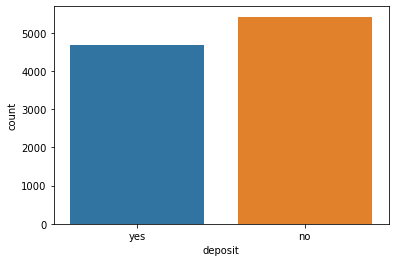

In [665]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
print(cleaned['deposit'].value_counts())
sns.countplot(data=cleaned, x='deposit');

Небольшая несбалансированность классов все же присутствует

### Задание 2

In [666]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задание 3

In [667]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#постройте визуализации, иллюстрирующие результаты

In [732]:
types = cleaned.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

['job', 'marital', 'contact', 'month', 'poutcome']

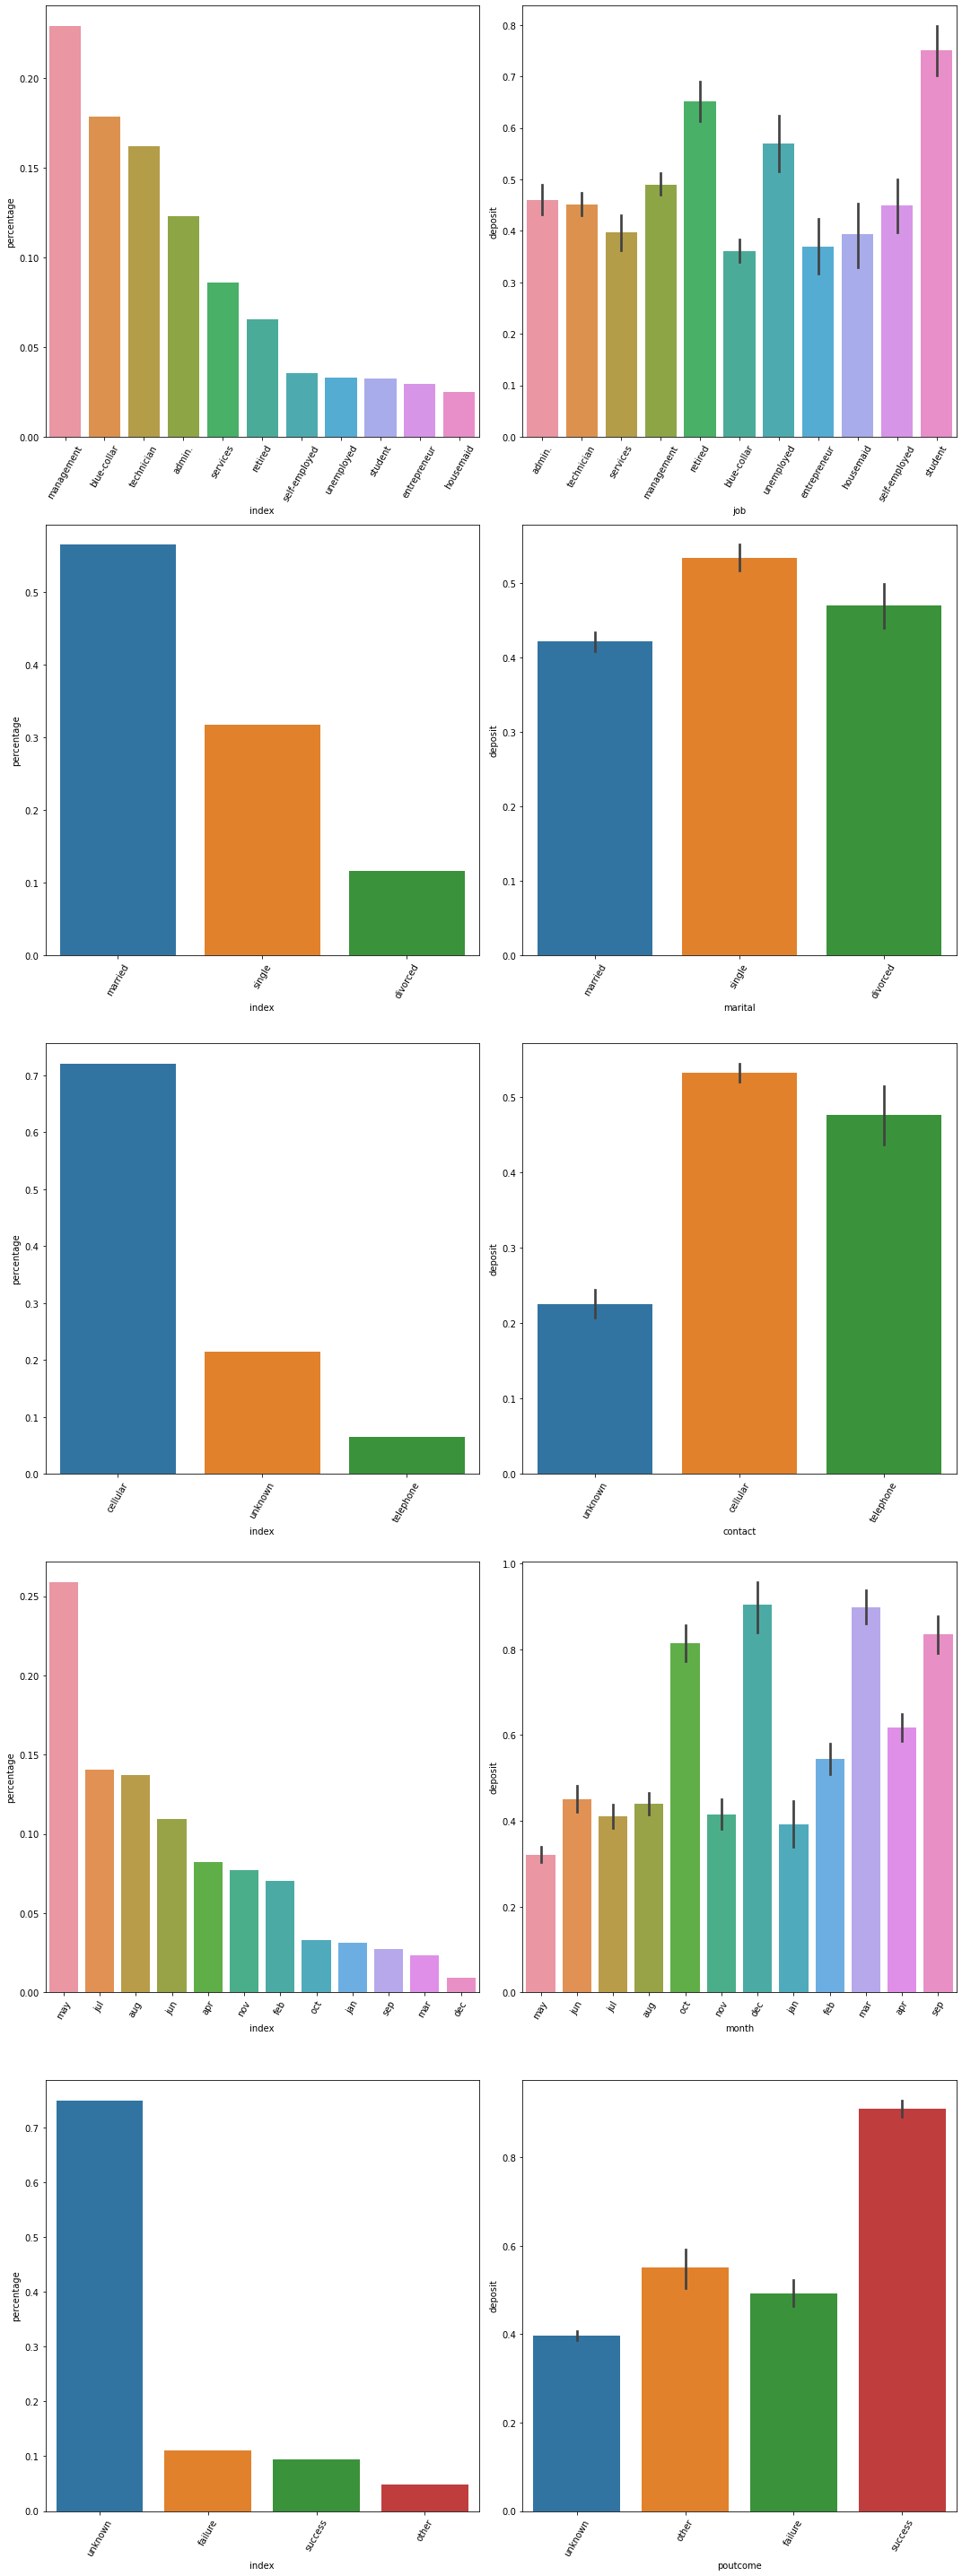

In [736]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаем цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    #Строим количественную столбчатую для долевого соотношения каждой из категорий в данных
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x='index', y='percentage', ax=axes[i][0])
    count_barplot.xaxis.set_tick_params(rotation=60)
    #Строим столбчатую диаграмму доли людей открывающих депозит в банке в зависимости от категории
    mean_barplot = sns.barplot(data=cleaned, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 4

In [670]:
cleaned['row']=np.arange(len(cleaned))

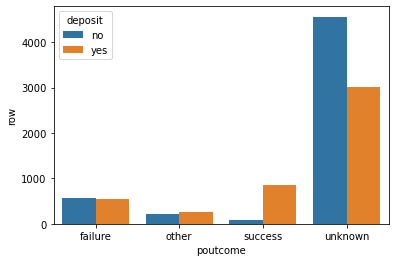

In [671]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
happy=cleaned.groupby(['poutcome','deposit'], as_index=False).count()
sns.barplot(data=happy, x='poutcome', y='row', hue='deposit');

Если в предыдущей маркетинговой кампании был успел (клиент открыл депозит), то в текущей маркенговой кампании тоже успех. Это логично, у людей появляется доверие к банку.

### Задание 5

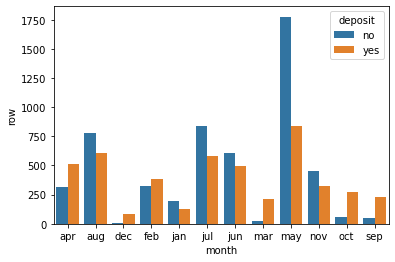

In [672]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
month=cleaned.groupby(['month','deposit'], as_index=False).count()
sns.barplot(data=month, x='month', y='row', hue='deposit');

Май - самый неудачный месяц для отклытия депозита, согласно статистике. Чтож, вероятнее всего, усиленно всего нужно маркетинговую кампанию в холодные месяца года. Вероятнее всего, люди открывают депозит, так как деньги могут "полежать" до лета и какая то сумма в виде начисленных процентов могла бы пригодиться летом для отдыха (поездки куда нибудь, к примеру).

### Задание 6

In [673]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def groups(row):
    if row < 30:
        return 0
    if (row > 30) and (row < 40):
        return 1
    if (row > 40) and (row < 50):
        return 2
    if (row > 50) and (row < 60):
        return 3
    if row > 60:
        return 4
    
cleaned['group']=cleaned['age'].apply(groups)

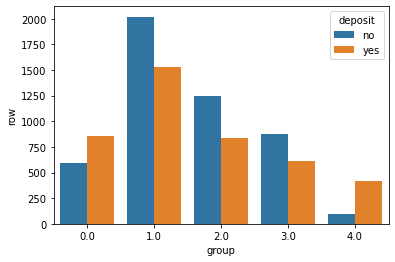

In [674]:
age=cleaned.groupby(['group','deposit'], as_index=False).count()
sns.barplot(data=age, x='group', y='row', hue='deposit');

Более склонны открывать депозит, нежели, чем отказываться от него либо молодые люди (до 30 лет), либо пожилые люди (после 60). Молодые люди, в частности студенты, могут покупать и отдавать банку ценные бумаги, либо просто вкладывать деньги опять же из за начисления процентов. Когда они решат обзавестись семьёй и купить квартиру, тогда они снимут эти деньги. Пожилые люди (после 60) могут помогать своим внукам и положить приличную сумму под хорошие проценты в банк.

### Задание 7

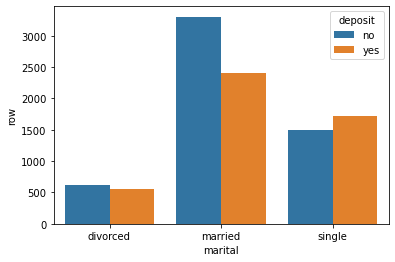

In [675]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
family=cleaned.groupby(['marital','deposit'], as_index=False).count()
sns.barplot(data=family, x='marital', y='row', hue='deposit');

Тут можно обойтись одним комментарием: пока ты одинок - можно и подкопить.

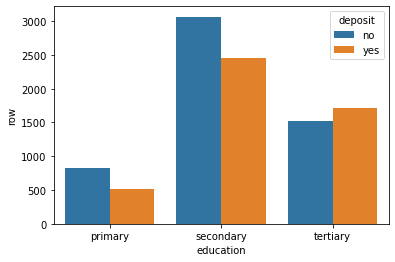

In [676]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
edu=cleaned.groupby(['education','deposit'], as_index=False).count()
sns.barplot(data=edu, x='education', y='row', hue='deposit');

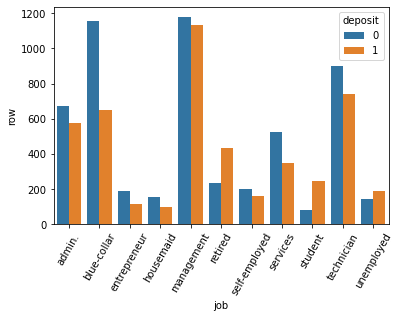

In [737]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job=cleaned.groupby(['job','deposit'], as_index=False).count()
j=sns.barplot(data=job, x='job', y='row', hue='deposit');
j.xaxis.set_tick_params(rotation=60)

In [678]:
cleaned['job'].value_counts()

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

### Задание 8

In [679]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
on=cleaned[cleaned['deposit']=='yes']
off=cleaned[cleaned['deposit']=='no']

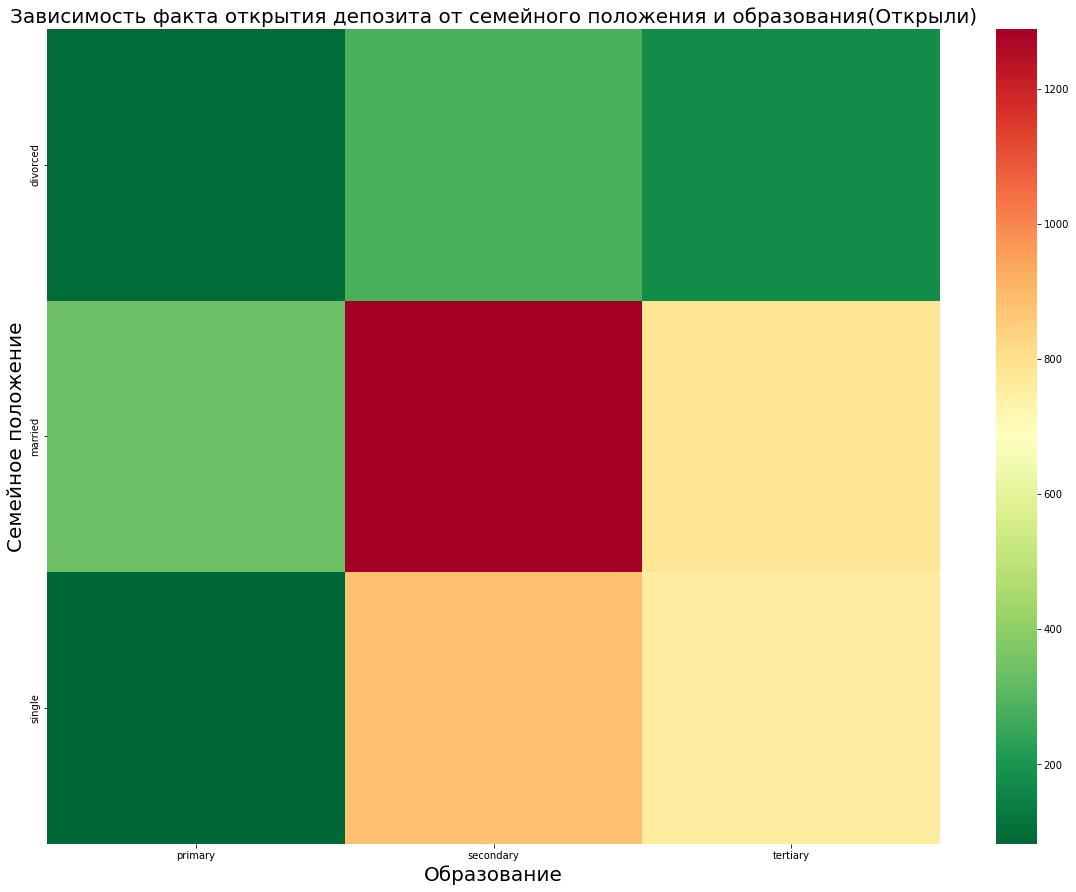

In [680]:
#Сводная таблица, иллюстрирующая зависимость факта открытия депозита от семейного положения и образования
pivot=on.pivot_table(values='deposit',index='marital', columns='education',aggfunc='count')

fig = plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(
    data=pivot, 
    cmap='RdYlGn_r'
)

heatmap.set_title('Зависимость факта открытия депозита от семейного положения и образования(Открыли)', fontsize=20)
heatmap.set_xlabel('Образование',fontsize=20)
heatmap.set_ylabel('Семейное положение',fontsize=20);

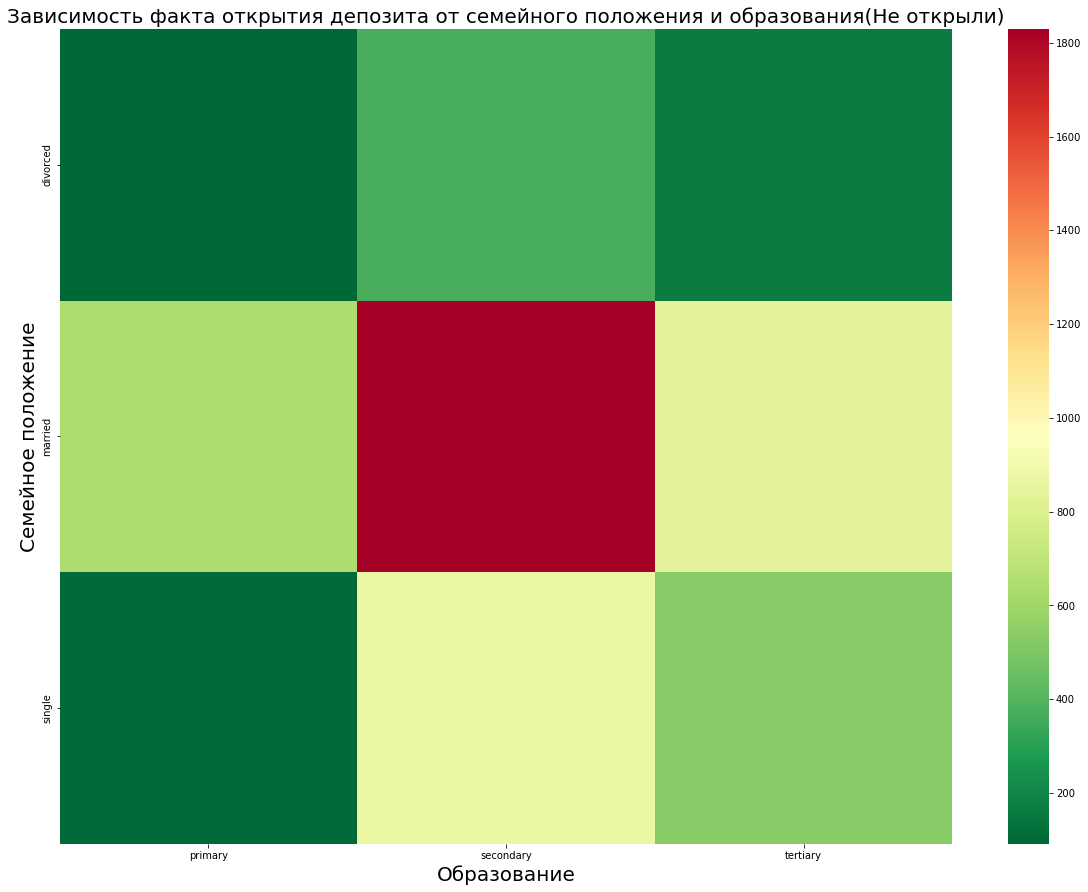

In [681]:
#Сводная таблица, иллюстрирующая зависимость факта открытия депозита от семейного положения и образования (Не открыли депозит)
pivot=off.pivot_table(values='deposit',index='marital', columns='education',aggfunc='count')

fig = plt.figure(figsize=(20, 15))
heatmap = sns.heatmap(
    data=pivot, 
    cmap='RdYlGn_r'
)

heatmap.set_title('Зависимость факта открытия депозита от семейного положения и образования(Не открыли)', fontsize=20)
heatmap.set_xlabel('Образование',fontsize=20)
heatmap.set_ylabel('Семейное положение',fontsize=20);

Люди с университетским образованием и женатые наиболее многочисленны в этой статистике.

## Часть 3: преобразование данных

### Задание 1

In [682]:
# преобразуйте уровни образования
labelencoder=LabelEncoder()
cleaned['education']=labelencoder.fit_transform(cleaned['education'])

In [683]:
cleaned['education'].sum()

11995

In [684]:
# преобразуйте порядковый признак возраста
labelencoder=LabelEncoder()
cleaned['group']=labelencoder.fit_transform(cleaned['group'])

### Задание 2

In [685]:
# преобразуйте бинарные переменные в представление из нулей и единиц
cleaned['deposit']=cleaned['deposit'].apply(lambda row: 1 if 'yes' in row else 0)

In [686]:
cleaned['deposit'].std()

0.4986712532451993

Сделаем то же самое для других бинарных переменных, которых у нас три: 'default', 'housing', 'loan'.

In [687]:
cleaned['default']=cleaned['default'].apply(lambda row: 1 if 'yes' in row else 0)
cleaned['housing']=cleaned['housing'].apply(lambda row: 1 if 'yes' in row else 0)
cleaned['loan']=cleaned['loan'].apply(lambda row: 1 if 'yes' in row else 0)

In [688]:
round((cleaned['default'].mean())+(cleaned['housing'].mean())+(cleaned['loan'].mean()),3)

0.635

### Задание 3

In [689]:
# создайте дамми-переменные
categorial_features=['job','marital','contact','month','poutcome']
cleaned_new = pd.get_dummies(cleaned[categorial_features])
cleaned=pd.concat([cleaned, cleaned_new], axis=1)

In [690]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   job                10105 non-null  object 
 2   marital            10105 non-null  object 
 3   education          10105 non-null  int32  
 4   default            10105 non-null  int64  
 5   balance            10105 non-null  float64
 6   housing            10105 non-null  int64  
 7   loan               10105 non-null  int64  
 8   contact            10105 non-null  object 
 9   day                10105 non-null  int64  
 10  month              10105 non-null  object 
 11  duration           10105 non-null  int64  
 12  campaign           10105 non-null  int64  
 13  pdays              10105 non-null  int64  
 14  previous           10105 non-null  int64  
 15  poutcome           10105 non-null  object 
 16  deposit            101

### Задание 4

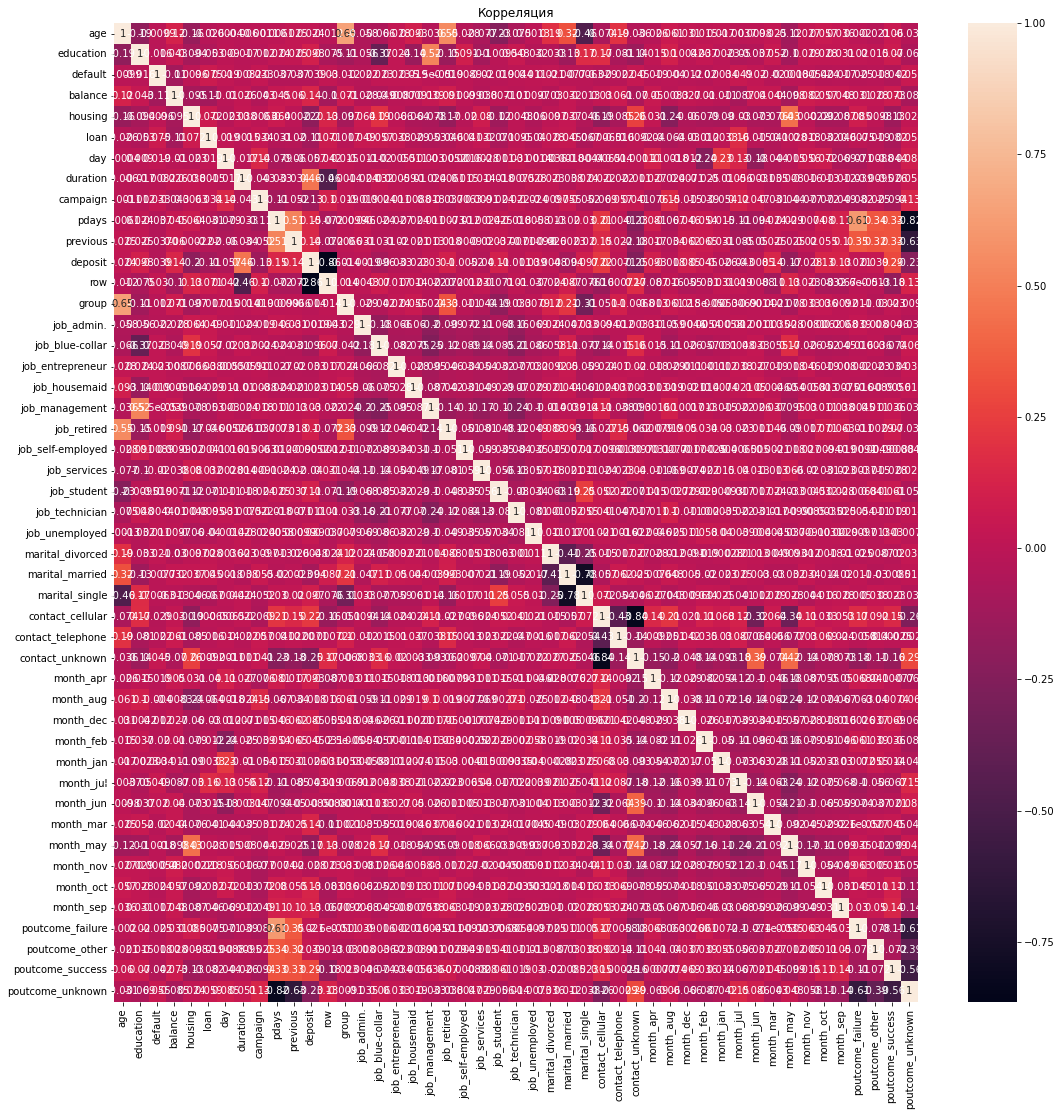

In [691]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(18,18))
ax =sns.heatmap(cleaned.corr(), annot=True)
ax.set_title("Корреляция")
plt.show()

Если считать достаточно сильной корреляцией (мультиколлинеарностью) значения не менее 0.9, то мультиколлинеарности не наблюдается.

### Задание 5

In [692]:
# определим отдельн целевую переменную (deposit) и предикторы
# разделим наши данные на тренировочную и тестовую выборки с сохранением соотношений целевой переменной 
X = cleaned.drop(['deposit','row'], axis=1)
y = cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [693]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 50)

In [694]:
round(y_test.mean(),2) #среднее значение целевой переменной на тестовой выборке

0.46

### Задание 6

In [695]:
#оставим только те признаки, которые содержат лишь числовые значения.
X_train = X_train.drop(['job','marital', 'contact', 'month', 'poutcome'], axis=1)
X_test = X_test.drop(['job','marital', 'contact', 'month', 'poutcome'], axis=1)

In [696]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = sklearn.feature_selection.SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
 
col=selector.get_feature_names_out()
col

array(['balance', 'housing', 'loan', 'duration', 'campaign', 'pdays',
       'previous', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [697]:
# создаем новые тренировочный и тестовый наборы из 15 наиболее подходящих признаков
X_train_new=X_train[col]
X_test_new=X_test[col]

### Задание 7

In [699]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train_new) # впринципе можно было бы сразу для тренировочной выборки fit_transform сделать
X_train_scaled = scaler.transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

In [700]:
round(X_test_scaled[:, 0].mean(),2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [702]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
#Обучаем модель
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [703]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      3634
           1       0.84      0.76      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задание 2

In [704]:
# обучите решающие деревья, настройте максимальную глубину
# Создаем объект класса дерево решений
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_depth=6,
    random_state=42
)
#Обучаем дерево по алгоритму CART
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [705]:
#Делаем предсказание для тренировочной выборки
y_train_pred = dt.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = dt.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3634
           1       0.82      0.77      0.80      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.81      0.81      6770
weighted avg       0.82      0.82      0.82      6770

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1790
           1       0.81      0.76      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335



### Задание 3

In [706]:
# подберите оптимальные параметры с помощью gridsearch
param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param_grid,  
    n_jobs = -1
)  

%time grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

Wall time: 4.61 s
accuracy на тестовом наборе: 0.79
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [707]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
random_forest = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    min_samples_leaf = 5,
    max_depth=10, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
random_forest.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred = random_forest.predict(X_test_scaled)
#Выводим отчет о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 2

In [710]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    min_samples_leaf=5, #минимальное число значений в классе
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
gb.fit(X_train_scaled, y_train)
y_pred = gb.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.83      0.82      0.82      3335



Качество обученной модели при помощи случаного леса лучше, чем при помощи градиентного бустинга

### Задание 3

In [719]:
# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', 
     tree.DecisionTreeClassifier(
         criterion='entropy',
         max_depth=6,
         random_state=42
     )),
    ('log_reg',
     linear_model.LogisticRegression(
         solver='sag',
         max_iter=1000,
         random_state=42
     )),
    ('gb',
     ensemble.GradientBoostingClassifier(
         learning_rate=0.05,
         n_estimators=300,
         min_samples_leaf=5,
         max_depth=5,
         random_state=42
     ))
]

#Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=ensemble.RandomForestClassifier(n_estimators=100,
                                          criterion='gini',
                                          min_samples_leaf = 5,
                                          max_depth=10, 
                                          random_state=42)
)

#Обучаем модель
reg.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=RandomForestClassifier(max_depth=10,
                                                          min_samples_leaf=5,
                                                          random_state=42))

In [720]:
y_pred = reg.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.82      0.83      0.82      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [741]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator = ensemble.GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train_new, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

Проиллюстрируем это на столбчатой диаграмме, чтобы понять важность этих признаков

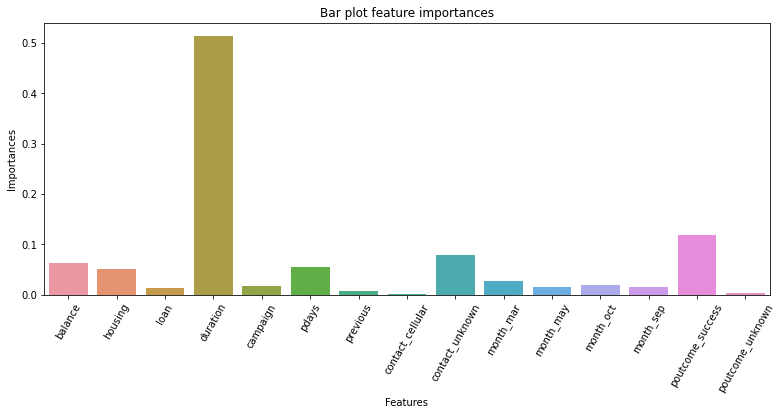

In [740]:
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train_new.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
fi=sns.barplot(x=feature, y=feature_importances, ax=ax);
fi.xaxis.set_tick_params(rotation=60)
#Добавляем подпись графику, осям абсцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

### Задание 5

In [728]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [729]:
%%time
# cоздаем объект исследования
# напрямую укажем, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-08-14 17:10:49,025] A new study created in memory with name: RandomForestClassifier
[I 2022-08-14 17:10:49,934] Trial 0 finished with value: 0.8428125 and parameters: {'n_estimators': 139, 'max_depth': 13, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8428125.
[I 2022-08-14 17:10:51,089] Trial 1 finished with value: 0.8457943925233645 and parameters: {'n_estimators': 168, 'max_depth': 20, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.8457943925233645.
[I 2022-08-14 17:10:52,267] Trial 2 finished with value: 0.8527204502814257 and parameters: {'n_estimators': 152, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8527204502814257.
[I 2022-08-14 17:10:53,087] Trial 3 finished with value: 0.8363295294669377 and parameters: {'n_estimators': 137, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.8527204502814257.
[I 2022-08-14 17:10:53,848] Trial 4 finished with value: 0.8490330630068622 and parameters: {'n_estimators': 119, 

Wall time: 31.8 s


In [730]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 199, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [731]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81


Можно сказать, что метрики не особенно улучшились по сравнению с предыдущими моделями. Они можно сказать такие же.